In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor


***Data Dividing***

In [3]:
import glob

chasedb1_path = '/media/mountHDD2/chasedb1'

image_files = glob.glob(chasedb1_path + '/*.jpg')
mask_files = glob.glob(chasedb1_path + '/*1stHO.png')

image_files.sort()
mask_files.sort()

img_dir = []
mask_dir = []

# Tạo danh sách các cặp (image, mask)
image_mask_pairs = [(image, mask) for image, mask in zip(image_files, mask_files)]

for pair in image_mask_pairs:
    img_dir.append(pair[0])  
    mask_dir.append(pair[1]) 

In [4]:
img_dir


['/media/mountHDD2/chasedb1/Image_01L.jpg',
 '/media/mountHDD2/chasedb1/Image_01R.jpg',
 '/media/mountHDD2/chasedb1/Image_02L.jpg',
 '/media/mountHDD2/chasedb1/Image_02R.jpg',
 '/media/mountHDD2/chasedb1/Image_03L.jpg',
 '/media/mountHDD2/chasedb1/Image_03R.jpg',
 '/media/mountHDD2/chasedb1/Image_04L.jpg',
 '/media/mountHDD2/chasedb1/Image_04R.jpg',
 '/media/mountHDD2/chasedb1/Image_05L.jpg',
 '/media/mountHDD2/chasedb1/Image_05R.jpg',
 '/media/mountHDD2/chasedb1/Image_06L.jpg',
 '/media/mountHDD2/chasedb1/Image_06R.jpg',
 '/media/mountHDD2/chasedb1/Image_07L.jpg',
 '/media/mountHDD2/chasedb1/Image_07R.jpg',
 '/media/mountHDD2/chasedb1/Image_08L.jpg',
 '/media/mountHDD2/chasedb1/Image_08R.jpg',
 '/media/mountHDD2/chasedb1/Image_09L.jpg',
 '/media/mountHDD2/chasedb1/Image_09R.jpg',
 '/media/mountHDD2/chasedb1/Image_10L.jpg',
 '/media/mountHDD2/chasedb1/Image_10R.jpg',
 '/media/mountHDD2/chasedb1/Image_11L.jpg',
 '/media/mountHDD2/chasedb1/Image_11R.jpg',
 '/media/mountHDD2/chasedb1/Imag

In [5]:
print(len(img_dir),len(mask_dir))

28 28


***Custorm Dataset***


In [6]:
class ChasedbT(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, target_transform=None):
        self.imgs = img_dir  
        self.msks = mask_dir 
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

In [7]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        #transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #The mean and std of ImageNet,Medical images must be counted separately 
    ]
)
#https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

Data_transfered = ChasedbT( img_dir=img_dir, mask_dir=mask_dir,transform = transform, target_transform=target_transform)
print(len(Data_transfered))

28


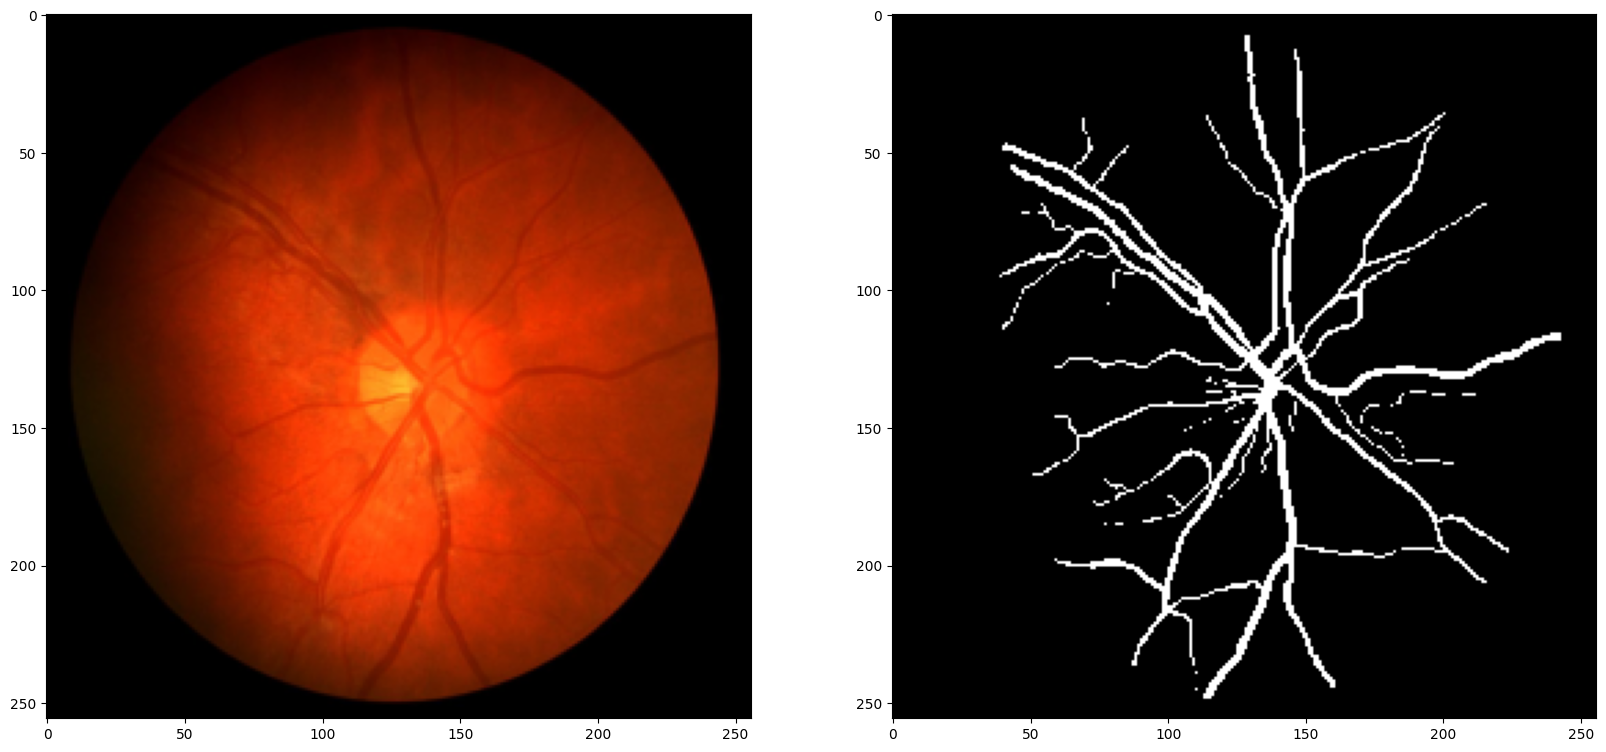

In [8]:

img, msk = Data_transfered[27]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20)) #tạo một figure chứa hai axes (ax1 và ax2) được sắp xếp theo hàng ngang với kích thước 20x20 inches
ax1.imshow(img.permute(1, -1, 0).numpy()) #Phương thức permute(1, -1, 0) được sử dụng để thay đổi chiều của tensor ,.numpy() chuyển đổi tensor thành mảng NumPy
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [9]:
from torch.utils.data.dataset import random_split
train_ds, test_ds = random_split(Data_transfered, [0.8, 0.2])

train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

print("Training Samples: {}".format(len(train_ds)))
print("Testing Samples: {}".format(len(test_ds)))

Training Samples: 23
Testing Samples: 5


In [10]:
sample_data, sample_mask = train_ds[10]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")

print(f"Number classes: {np.unique(sample_mask.numpy())}")

data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])
Number classes: [0. 1.]


***Training***

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [13]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [14]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [15]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [16]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False): # upsampling, Khi bilinear=False, mô hình sẽ sử dụng một phương pháp khác gọi là "transposed convolution" hoặc "deconvolution" để thực hiện upsampling
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [17]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = UNet(3, 1, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [19]:
old_loss = 1e26
best_dct = None
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()        
        
        tr_total_loss += train_loss.cpu().item()        
            
    mean_train_loss = tr_total_loss/len(train_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.78it/s]


Epoch: 0 - TrainLoss: 0.4883322430693585


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.55it/s]


Epoch: 1 - TrainLoss: 0.34775359086368396


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.58it/s]


Epoch: 2 - TrainLoss: 0.28064188490743225


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.78it/s]


Epoch: 3 - TrainLoss: 0.23723617520021356


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.46it/s]


Epoch: 4 - TrainLoss: 0.20295775454977286


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.72it/s]


Epoch: 5 - TrainLoss: 0.17659644069878952


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.43it/s]


Epoch: 6 - TrainLoss: 0.15797991078832876


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.14it/s]


Epoch: 7 - TrainLoss: 0.14300341774588046


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.63it/s]


Epoch: 8 - TrainLoss: 0.1313844274567521


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.24it/s]


Epoch: 9 - TrainLoss: 0.12235054697679437


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.92it/s]


Epoch: 10 - TrainLoss: 0.11591513325338779


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.38it/s]


Epoch: 11 - TrainLoss: 0.11027016782242319


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.70it/s]


Epoch: 12 - TrainLoss: 0.10368781472029893


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.76it/s]


Epoch: 13 - TrainLoss: 0.09911159652730693


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.73it/s]


Epoch: 14 - TrainLoss: 0.09538630525703015


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.62it/s]


Epoch: 15 - TrainLoss: 0.09135474653347679


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.84it/s]


Epoch: 16 - TrainLoss: 0.08781340005605118


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.95it/s]


Epoch: 17 - TrainLoss: 0.08561889406131662


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.30it/s]


Epoch: 18 - TrainLoss: 0.08258883979009546


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.63it/s]


Epoch: 19 - TrainLoss: 0.08017952707798584


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.80it/s]


Epoch: 20 - TrainLoss: 0.07899856956108757


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.89it/s]


Epoch: 21 - TrainLoss: 0.07593046987186307


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.90it/s]


Epoch: 22 - TrainLoss: 0.07441444111906964


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.75it/s]


Epoch: 23 - TrainLoss: 0.07287404005942137


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.90it/s]


Epoch: 24 - TrainLoss: 0.07040227917225464


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.98it/s]


Epoch: 25 - TrainLoss: 0.07124163842071658


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.28it/s]


Epoch: 26 - TrainLoss: 0.06995440938550493


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.06it/s]


Epoch: 27 - TrainLoss: 0.06758073571583499


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.86it/s]


Epoch: 28 - TrainLoss: 0.06473762250464896


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.26it/s]


Epoch: 29 - TrainLoss: 0.06337132466875989


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.69it/s]


Epoch: 30 - TrainLoss: 0.063084427267313


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.00it/s]


Epoch: 31 - TrainLoss: 0.060754280051459435


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.14it/s]


Epoch: 32 - TrainLoss: 0.05926785504688387


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.21it/s]


Epoch: 33 - TrainLoss: 0.05933314561843872


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.90it/s]


Epoch: 34 - TrainLoss: 0.056300688373005905


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.66it/s]


Epoch: 35 - TrainLoss: 0.054864060619603035


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.00it/s]


Epoch: 36 - TrainLoss: 0.05404931387823561


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.06it/s]


Epoch: 37 - TrainLoss: 0.052333816562009895


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.22it/s]


Epoch: 38 - TrainLoss: 0.04958870472467464


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.56it/s]


Epoch: 39 - TrainLoss: 0.04819624028776003


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.79it/s]


Epoch: 40 - TrainLoss: 0.04705683060962221


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.07it/s]


Epoch: 41 - TrainLoss: 0.045302649474014405


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.14it/s]


Epoch: 42 - TrainLoss: 0.044424430183742356


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.24it/s]


Epoch: 43 - TrainLoss: 0.042328979334105614


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.04it/s]


Epoch: 44 - TrainLoss: 0.04116657505864683


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.14it/s]


Epoch: 45 - TrainLoss: 0.03954685568485571


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.61it/s]


Epoch: 46 - TrainLoss: 0.03773976060683313


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.27it/s]


Epoch: 47 - TrainLoss: 0.03652977692368238


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 43.01it/s]


Epoch: 48 - TrainLoss: 0.03358789460490579


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.33it/s]


Epoch: 49 - TrainLoss: 0.031775773705347725


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.79it/s]


Epoch: 50 - TrainLoss: 0.03069891983076282


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.46it/s]


Epoch: 51 - TrainLoss: 0.030143827280920486


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.40it/s]


Epoch: 52 - TrainLoss: 0.028491777408382168


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.99it/s]


Epoch: 53 - TrainLoss: 0.027020272920313088


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.77it/s]


Epoch: 54 - TrainLoss: 0.025432317558190098


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.76it/s]


Epoch: 55 - TrainLoss: 0.021906213025036064


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.74it/s]


Epoch: 56 - TrainLoss: 0.02070797097099864


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.82it/s]


Epoch: 57 - TrainLoss: 0.018702466648233974


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 43.82it/s]


Epoch: 58 - TrainLoss: 0.017622783577636532


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 58.82it/s]


Epoch: 59 - TrainLoss: 0.017535507921939312


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 60.18it/s]


Epoch: 60 - TrainLoss: 0.017470624581303284


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 53.22it/s]


Epoch: 61 - TrainLoss: 0.01573458504255699


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.52it/s]


Epoch: 62 - TrainLoss: 0.013993650026943373


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 43.16it/s]


Epoch: 63 - TrainLoss: 0.012898120624215706


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 59.52it/s]


Epoch: 64 - TrainLoss: 0.014183405341337557


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 61.63it/s]


Epoch: 65 - TrainLoss: 0.01611786655595769


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 59.46it/s]


Epoch: 66 - TrainLoss: 0.017873473789380943


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 58.44it/s]


Epoch: 67 - TrainLoss: 0.01462059561163187


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 49.32it/s]


Epoch: 68 - TrainLoss: 0.011309839278945456


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.99it/s]


Epoch: 69 - TrainLoss: 0.00898651594458067


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.60it/s]


Epoch: 70 - TrainLoss: 0.007367629092186689


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.29it/s]


Epoch: 71 - TrainLoss: 0.006530540853576816


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.49it/s]


Epoch: 72 - TrainLoss: 0.00545264027364876


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.42it/s]


Epoch: 73 - TrainLoss: 0.004762774718034527


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.11it/s]


Epoch: 74 - TrainLoss: 0.0049789534152849865


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.44it/s]


Epoch: 75 - TrainLoss: 0.004381141220421895


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.94it/s]


Epoch: 76 - TrainLoss: 0.0037207512853100247


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.36it/s]


Epoch: 77 - TrainLoss: 0.0030697308703447166


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.45it/s]


Epoch: 78 - TrainLoss: 0.0027022433426717053


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.92it/s]


Epoch: 79 - TrainLoss: 0.0023620110561909237


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.92it/s]


Epoch: 80 - TrainLoss: 0.0018116086012805285


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.54it/s]


Epoch: 81 - TrainLoss: 0.0014701998316804352


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.60it/s]


Epoch: 82 - TrainLoss: 0.0012392708070009298


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.07it/s]


Epoch: 83 - TrainLoss: 0.0010630302384252782


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.01it/s]


Epoch: 84 - TrainLoss: 0.0009561608616343659


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.94it/s]


Epoch: 85 - TrainLoss: 0.0008834791926505125


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.74it/s]


Epoch: 86 - TrainLoss: 0.0008239571673228689


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.92it/s]


Epoch: 87 - TrainLoss: 0.0007697620591067749


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.82it/s]


Epoch: 88 - TrainLoss: 0.0007293871578598476


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.28it/s]


Epoch: 89 - TrainLoss: 0.0006908845667646307


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.31it/s]


Epoch: 90 - TrainLoss: 0.0006597842945231367


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.48it/s]


Epoch: 91 - TrainLoss: 0.0006310185088533099


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.77it/s]


Epoch: 92 - TrainLoss: 0.0006035802475905613


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.39it/s]


Epoch: 93 - TrainLoss: 0.000579148379114011


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.65it/s]


Epoch: 94 - TrainLoss: 0.00055541365366915


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.13it/s]


Epoch: 95 - TrainLoss: 0.0005334042640321928


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.39it/s]


Epoch: 96 - TrainLoss: 0.0005130813591202478


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.63it/s]


Epoch: 97 - TrainLoss: 0.0004945968748475223


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.28it/s]


Epoch: 98 - TrainLoss: 0.0004770667735062054


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.42it/s]

Epoch: 99 - TrainLoss: 0.00045966403179235107


<All keys matched successfully>

In [20]:
torch.save(best_dct, 'parameter_unet_v1.pth')

In [21]:
#best_model = AttU_Net()  
#best_model.load_state_dict(torch.load('parameter_unet_v1.pth'))

In [22]:
test_img_dir= '/home/chuyenmt/Chuyen_explore-Copy1/Test_Drive'

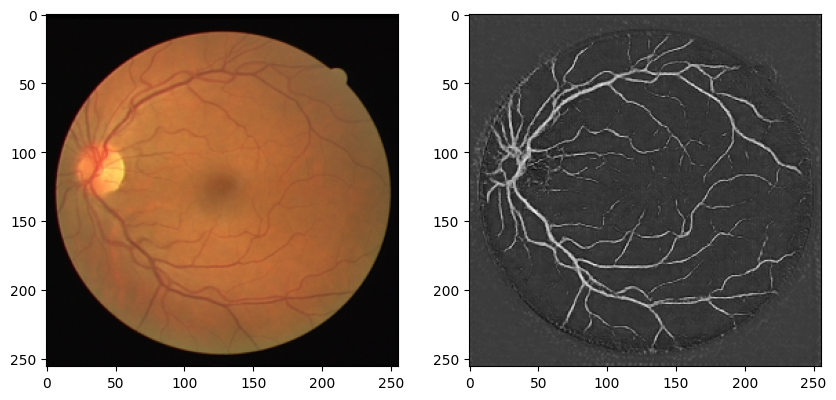

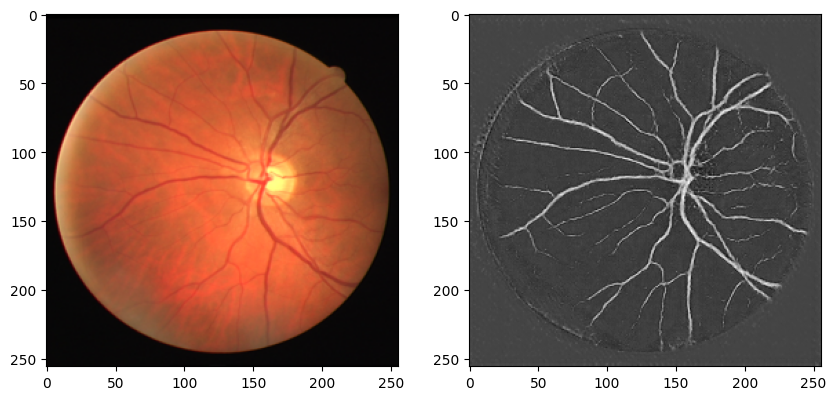

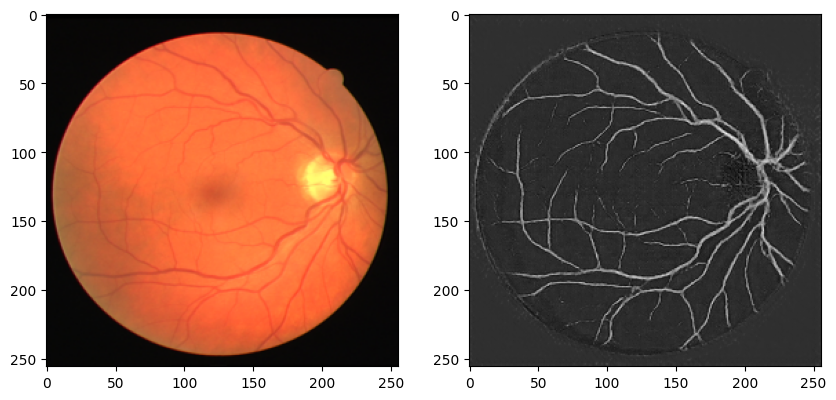

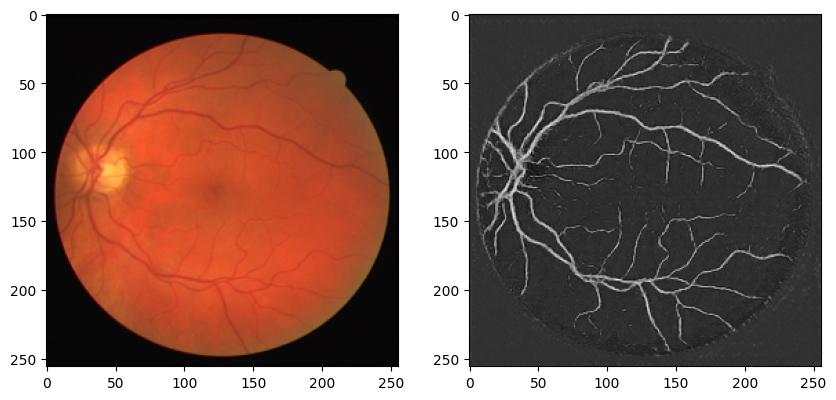

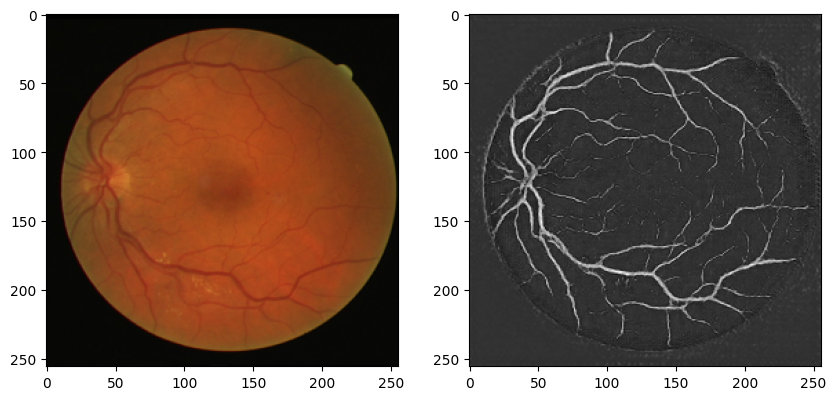

In [23]:
from glob import glob
for test_img_path in glob(test_img_dir + "/*"):
    img = transform(Image.open(test_img_path)).to(device).unsqueeze(0)

    mask = model(img)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(mask[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')
